In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from src.directories import processed_data_dir, saved_model_dir, vis_dir
from src.utils import WindowGenerator, get_filenames_in_directory, ModelTrainer

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [4]:
# check GPU visibility
tf.config.get_visible_devices(
    device_type='GPU'
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
train_dir = processed_data_dir / 'train'
val_dir = processed_data_dir / 'val'
test_dir = processed_data_dir / 'test'

In [6]:
train_files = get_filenames_in_directory(train_dir)

In [7]:
# number of features
# 11
cols = pd.read_csv(train_dir/train_files[0]).columns
n_features = len(cols) -1  # number of columns without embedding column
n_features

11

In [8]:
# number of locations for embedding inputs
# 6
train_files = get_filenames_in_directory(train_dir)
n_locations = len(train_files)
n_locations

6

In [9]:
# Model configs
INPUT_WIDTH = 24  * 3
LABEL_WIDTH = 24
BATCH_SIZE = 32
N_FEATURES = n_features
N_OUTPUTS = 1
N_EMBEDDING_DIMS = n_locations

In [10]:
w1 = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, batch_size=BATCH_SIZE,
                     train_dir=train_dir, val_dir=val_dir, test_dir=test_dir,
                     label_columns=['Lufttemperatur [GradC]'],
                     embedding_column='Location')

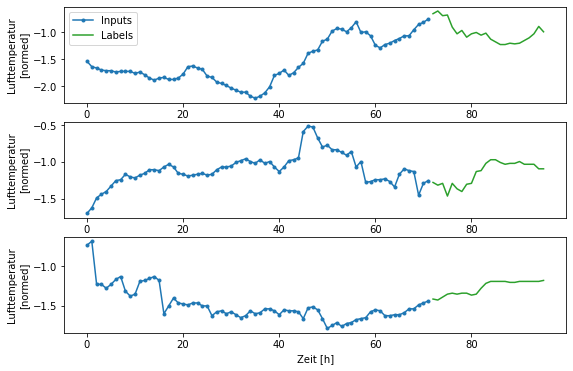

In [11]:
w1.plot(rotate_examples=False)

In [12]:
# container to store model performances
performance = {}

# Baseline model 1: Repeat last hour

In [13]:
# example for testing
# for example in w1.train.take(1):
#     (inputs, embeddings), y = example

In [14]:
class LastStepBaseline(tf.keras.Model):
  def call(self, inputs):
    features, _ = inputs

    temp_at_last_t = tf.expand_dims(features[:, -1:, 1], axis=2)

    return tf.tile(temp_at_last_t, [1, LABEL_WIDTH, 1])

In [15]:
last_step_baseline = ModelTrainer(
    model=LastStepBaseline(),
    name='Last Step Baseline',
    train_dataset = w1.train,
    validation_dataset = w1.val,
    test_dataset = w1.test
)

performance[last_step_baseline.name] = last_step_baseline.evaluate()

546/546 [==============================] - 6s 10ms/step - loss: 0.2919


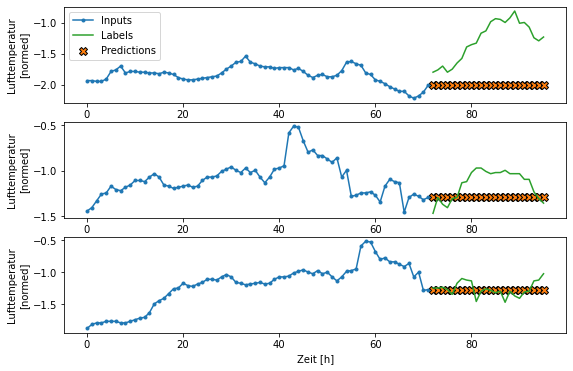

In [16]:
w1.plot(last_step_baseline.model, rotate_examples=True)

# Baseline model 2: Repeat last 24h

In [17]:
class LastDayBaseline(tf.keras.Model):
  def call(self, inputs):
    features, _ = inputs

    return tf.expand_dims(features[:,-24:, 1], axis=2)

In [18]:
last_day_baseline = ModelTrainer(
    model=LastDayBaseline(),
    name='Last Day Baseline',
    train_dataset = w1.train,
    validation_dataset = w1.val,
    test_dataset = w1.test
)

performance[last_day_baseline.name] = last_day_baseline.evaluate()

546/546 [==============================] - 5s 9ms/step - loss: 0.1812


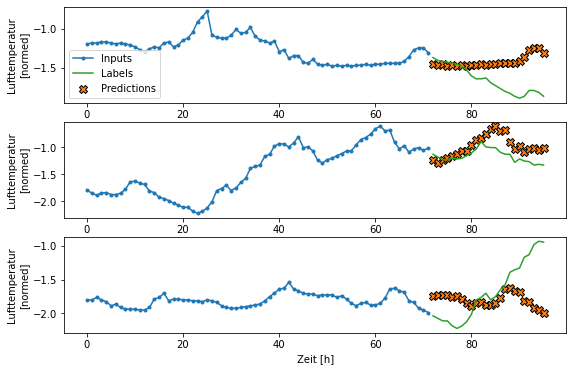

In [19]:
w1.plot(last_day_baseline.model, rotate_examples=True)

# Single layer LSTM w/o embedding

In [20]:
tf.keras.backend.clear_session()

# Deadend input for embeddings
_ = tf.keras.Input(shape =(INPUT_WIDTH, ))

# Input for features
feature_inputs = tf.keras.layers.Input(shape=(INPUT_WIDTH, n_features))

lstm = tf.keras.layers.LSTM(30, return_sequences=False)(feature_inputs)

# Apply a dense output layer on the output of the last timestep
dense = tf.keras.layers.Dense(LABEL_WIDTH)(lstm)

# Reshape outputs
output = tf.keras.layers.Reshape([LABEL_WIDTH, 1])(dense)

# Build the model
model = tf.keras.Model(inputs=[feature_inputs, _], outputs=output)

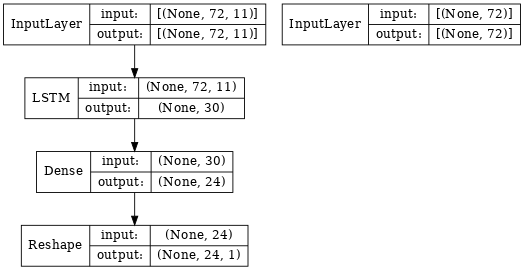

In [21]:
basic_lstm = ModelTrainer(
    model,
    name='LSTM w/o embedding',
    train_dataset=w1.train,
    validation_dataset=w1.val,
    test_dataset=w1.test,
    saved_model_dir=saved_model_dir,
    vis_dir=vis_dir
)

basic_lstm.plot_model()

In [22]:
basic_lstm.fit()

Epoch 1/30
3282/3282 [==============================] - 94s 28ms/step - loss: 0.5400 - val_loss: 0.1445
Epoch 2/30
3282/3282 [==============================] - 93s 28ms/step - loss: 0.1356 - val_loss: 0.1126
Epoch 3/30
3282/3282 [==============================] - 98s 30ms/step - loss: 0.1143 - val_loss: 0.1042
Epoch 4/30
3282/3282 [==============================] - 98s 30ms/step - loss: 0.1065 - val_loss: 0.1006
Epoch 5/30
3282/3282 [==============================] - 123s 37ms/step - loss: 0.1013 - val_loss: 0.0967
Epoch 6/30
3282/3282 [==============================] - 130s 40ms/step - loss: 0.0974 - val_loss: 0.0939
Epoch 7/30
3282/3282 [==============================] - 132s 40ms/step - loss: 0.0946 - val_loss: 0.0917
Epoch 8/30
3282/3282 [==============================] - 134s 41ms/step - loss: 0.0921 - val_loss: 0.0903
Epoch 9/30
3282/3282 [==============================] - 130s 40ms/step - loss: 0.0902 - val_loss: 0.0886
Epoch 10/30
3282/3282 [==============================] - 13

INFO:tensorflow:Assets written to: /home/heckert/projects/sbg-weather/data/saved_models/lstm_wo_embedding_2021-09-28/assets


INFO:tensorflow:Assets written to: /home/heckert/projects/sbg-weather/data/saved_models/lstm_wo_embedding_2021-09-28/assets


Saved trained model at /home/heckert/projects/sbg-weather/data/saved_models/lstm_wo_embedding_2021-09-28


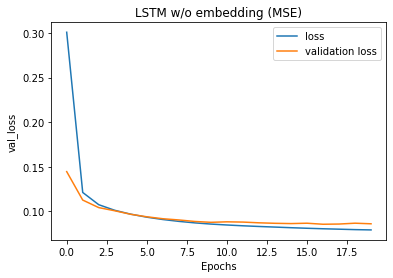

In [23]:
basic_lstm.plot_history()

In [24]:
performance[basic_lstm.name] = basic_lstm.evaluate()

546/546 [==============================] - 6s 11ms/step - loss: 0.0920


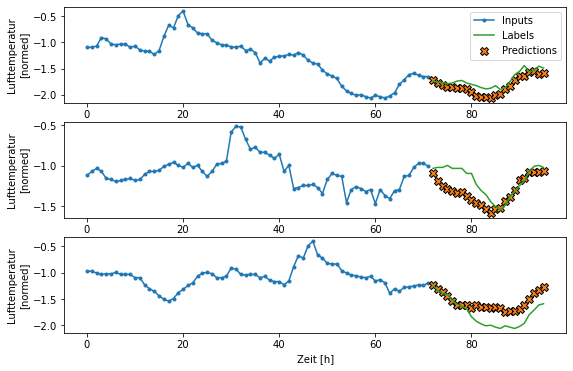

In [25]:
w1.plot(basic_lstm.model, rotate_examples=True)

# Single layer LSTM w embedding

In [26]:
tf.keras.backend.clear_session()

# Input for embeddings
embedding_inputs = tf.keras.Input(shape =(INPUT_WIDTH, ))
embedding_layer = tf.keras.layers.Embedding(input_dim=N_EMBEDDING_DIMS + 1, 
                                            output_dim=2, input_length=INPUT_WIDTH)(embedding_inputs)

# Input for features
feature_inputs = tf.keras.layers.Input(shape=(INPUT_WIDTH, n_features))

# Concat embeddings &  features
concat_layer = tf.keras.layers.Concatenate()([embedding_layer, feature_inputs])

lstm = tf.keras.layers.LSTM(30, return_sequences=False)(concat_layer)

# Apply a dense output layer on the output of the last timestep
dense = tf.keras.layers.Dense(LABEL_WIDTH)(lstm)

# Reshape outputs
output = tf.keras.layers.Reshape([LABEL_WIDTH, 1])(dense)

# Build the model
model = tf.keras.Model(inputs=[feature_inputs, embedding_inputs], outputs=output)

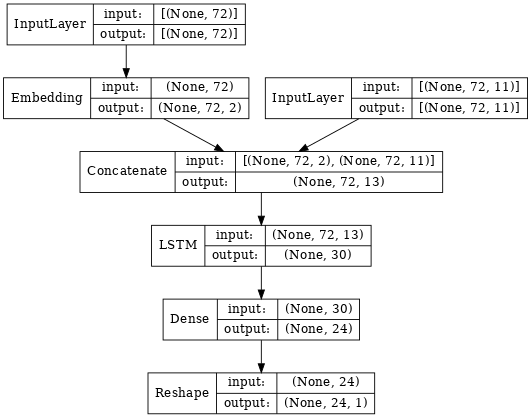

In [27]:
lstm_w_emb = ModelTrainer(
    model,
    name='LSTM with embedding',
    train_dataset=w1.train,
    validation_dataset=w1.val,
    test_dataset=w1.test,
    saved_model_dir=saved_model_dir,
    vis_dir=vis_dir
)

lstm_w_emb.plot_model()

In [28]:
lstm_w_emb.fit()

Epoch 1/30
3282/3282 [==============================] - 107s 32ms/step - loss: 0.5824 - val_loss: 0.1558
Epoch 2/30
3282/3282 [==============================] - 85s 26ms/step - loss: 0.1417 - val_loss: 0.1123
Epoch 3/30
3282/3282 [==============================] - 83s 25ms/step - loss: 0.1148 - val_loss: 0.1025
Epoch 4/30
3282/3282 [==============================] - 89s 27ms/step - loss: 0.1049 - val_loss: 0.0964
Epoch 5/30
3282/3282 [==============================] - 78s 24ms/step - loss: 0.0984 - val_loss: 0.0924
Epoch 6/30
3282/3282 [==============================] - 92s 28ms/step - loss: 0.0941 - val_loss: 0.0899
Epoch 7/30
3282/3282 [==============================] - 90s 27ms/step - loss: 0.0909 - val_loss: 0.0878
Epoch 8/30
3282/3282 [==============================] - 113s 34ms/step - loss: 0.0886 - val_loss: 0.0865
Epoch 9/30
3282/3282 [==============================] - 136s 41ms/step - loss: 0.0867 - val_loss: 0.0854
Epoch 10/30
3282/3282 [==============================] - 106s

INFO:tensorflow:Assets written to: /home/heckert/projects/sbg-weather/data/saved_models/lstm_with_embedding_2021-09-28/assets


INFO:tensorflow:Assets written to: /home/heckert/projects/sbg-weather/data/saved_models/lstm_with_embedding_2021-09-28/assets


Saved trained model at /home/heckert/projects/sbg-weather/data/saved_models/lstm_with_embedding_2021-09-28


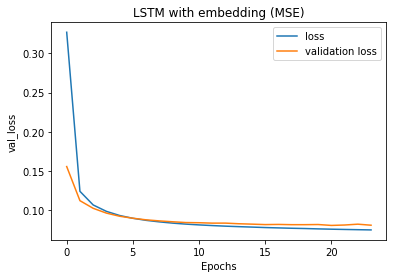

In [29]:
lstm_w_emb.plot_history()

In [30]:
performance[lstm_w_emb.name] = lstm_w_emb.evaluate()

546/546 [==============================] - 8s 14ms/step - loss: 0.0886


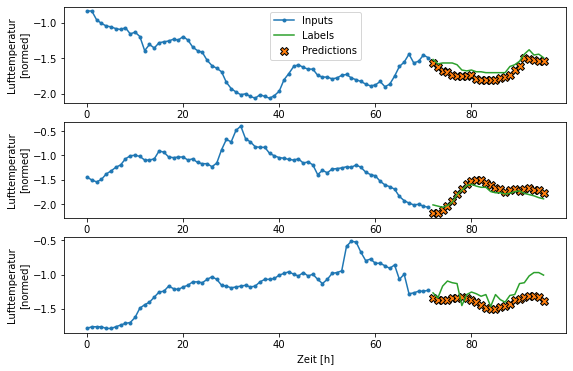

In [53]:
w1.plot(lstm_w_emb.model, rotate_examples=True)

# Multi layer LSTM

In [32]:
tf.keras.backend.clear_session()

# Input for embeddings
embedding_inputs = tf.keras.Input(shape =(INPUT_WIDTH, ))
embedding_layer = tf.keras.layers.Embedding(input_dim=N_EMBEDDING_DIMS + 1, 
                                            output_dim=2, input_length=INPUT_WIDTH)(embedding_inputs)

# Input for features
feature_inputs = tf.keras.layers.Input(shape=(INPUT_WIDTH, n_features))

# Concat embeddings &  features
concat_layer = tf.keras.layers.Concatenate()([embedding_layer, feature_inputs])

lstm = tf.keras.layers.LSTM(30, return_sequences=True)(concat_layer)
lstm = tf.keras.layers.LSTM(30, return_sequences=False)(lstm)

# Apply a dense output layer on the output of the last timestep
dense = tf.keras.layers.Dense(LABEL_WIDTH)(lstm)

# Reshape outputs
output = tf.keras.layers.Reshape([LABEL_WIDTH, 1])(dense)

# Build the model
model = tf.keras.Model(inputs=[feature_inputs, embedding_inputs], outputs=output)

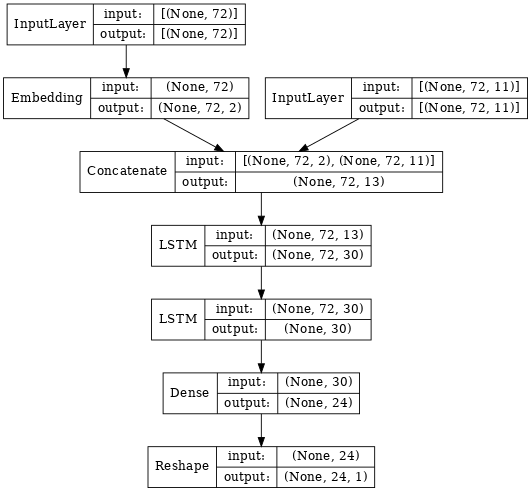

In [33]:
multi_lstm = ModelTrainer(
    model,
    name='Multi layer LSTM with embedding',
    train_dataset=w1.train,
    validation_dataset=w1.val,
    test_dataset=w1.test,
    saved_model_dir=saved_model_dir,
    vis_dir=vis_dir
)

multi_lstm.plot_model()

In [34]:
multi_lstm.fit()

Epoch 1/30
3282/3282 [==============================] - 145s 43ms/step - loss: 0.5574 - val_loss: 0.1469
Epoch 2/30
3282/3282 [==============================] - 142s 43ms/step - loss: 0.1348 - val_loss: 0.1132
Epoch 3/30
3282/3282 [==============================] - 135s 41ms/step - loss: 0.1133 - val_loss: 0.1047
Epoch 4/30
3282/3282 [==============================] - 141s 43ms/step - loss: 0.1035 - val_loss: 0.0981
Epoch 5/30
3282/3282 [==============================] - 129s 39ms/step - loss: 0.0972 - val_loss: 0.0953
Epoch 6/30
3282/3282 [==============================] - 140s 43ms/step - loss: 0.0930 - val_loss: 0.0920
Epoch 7/30
3282/3282 [==============================] - 125s 38ms/step - loss: 0.0897 - val_loss: 0.0908
Epoch 8/30
3282/3282 [==============================] - 134s 41ms/step - loss: 0.0872 - val_loss: 0.0880
Epoch 9/30
3282/3282 [==============================] - 139s 42ms/step - loss: 0.0852 - val_loss: 0.0866
Epoch 10/30
3282/3282 [==============================] 

INFO:tensorflow:Assets written to: /home/heckert/projects/sbg-weather/data/saved_models/multi_layer_lstm_with_embedding_2021-09-28/assets


INFO:tensorflow:Assets written to: /home/heckert/projects/sbg-weather/data/saved_models/multi_layer_lstm_with_embedding_2021-09-28/assets


Saved trained model at /home/heckert/projects/sbg-weather/data/saved_models/multi_layer_lstm_with_embedding_2021-09-28


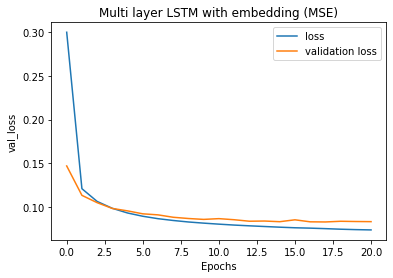

In [35]:
multi_lstm.plot_history()

In [36]:
performance[multi_lstm.name] = multi_lstm.evaluate()

546/546 [==============================] - 13s 23ms/step - loss: 0.0899


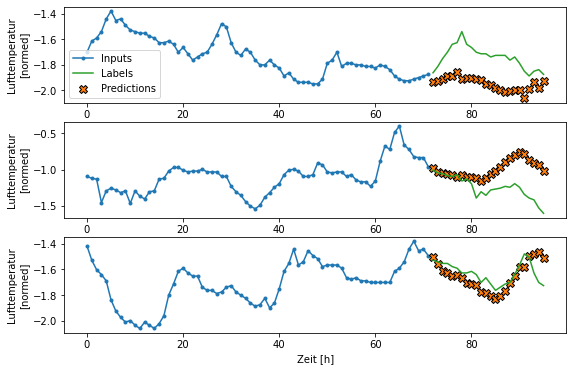

In [37]:
w1.plot(multi_lstm.model, rotate_examples=True)

# Evaluation

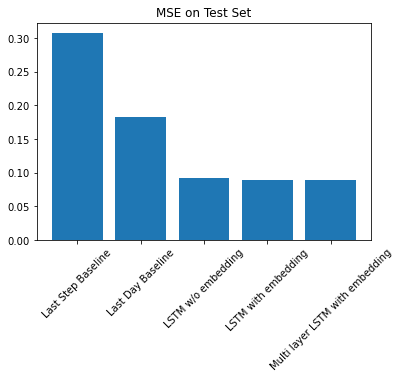

In [38]:
models = performance.keys()
mse = performance.values()
x = range(len(models))

plt.bar(x, mse, label=models)
plt.xticks(ticks=x, labels=models,
           rotation=45)
plt.title('MSE on Test Set')
plt.savefig(vis_dir/'evaluation.png')
plt.show()